## Evaluating the Perfromance of the AI model by Molecule type

Finding the generalization gap by finding the average f1 score for each molecule type in the training and validating data, then finding the difference in average f1 score between training and validating data. Explores the relationship between number of datapoints of molecule type in training data and memorization score.


In [40]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tr_data = [] #empty list to hold data
vl_data = []

data_path = '/Users/ilanastern/Documents/GitHub/aiConfidential/data' 

# Walk through all directories and subdirectories in the 'data' folder
for root, dirs, files in os.walk(data_path):
    # Check if we are in a TR.eval or VL.eval folder
    if root.endswith('_TR.eval') or root.endswith('_VL.eval'):
        for file in files:
            # Check if the file is 'eval_loss_meta'
            if file.startswith('eval_loss_meta'):
                file_path = os.path.join(root, file)
                # Read the file into a DataFrame
                df = pd.read_csv(file_path)  # Adjust if not CSV, e.g., pd.read_excel for .xls
                # Append to the appropriate list
                if root.endswith('_TR.eval'):
                    tr_data.append(df)
                elif root.endswith('_VL.eval'):
                    vl_data.append(df)

# Concatenate all dataframes into one for TR and one for VL
tr_df = pd.concat(tr_data, ignore_index=True)
vl_df = pd.concat(vl_data, ignore_index=True)



In [41]:
tr_df_sorted = tr_df.sort_values(by='moltype') # sorting the data by moltype
vl_df_sorted = vl_df.sort_values(by='moltype')

# Create separate dataframes for each 'moltype' in TR and VL
tr_moltype_groups = {moltype: group for moltype, group in tr_df_sorted.groupby('moltype')}
vl_moltype_groups = {moltype: group for moltype, group in vl_df_sorted.groupby('moltype')}

print(tr_moltype_groups.keys()) #prints the names of different types of molecules in the training data
print(vl_moltype_groups.keys()) #prints the names of different types of molecules in the validation data
# There are 9 different types of molecules.
#print(tr_moltype_groups['16S-rRNA']) As an example, prints the data for the 16S-rRNA molecule in the training data

dict_keys(['16S-rRNA', '23S-rRNA', '5S-rRNA', 'RNaseP', 'SRP', 'TERC', 'gpI-intron', 'tRNA', 'tmRNA'])
dict_keys(['16S-rRNA', '23S-rRNA', '5S-rRNA', 'RNaseP', 'SRP', 'TERC', 'gpI-intron', 'tRNA', 'tmRNA'])


## Data table and graph of memorization scores by molecule type

In [49]:
tr_f1_scores = [] # Empty lists to hold the moltype name and F1 scores for TR and VL data
vl_f1_scores = []
table_data = [] #empty list to hold the data for the table

# Calculate average F1 score for each molecule type in TR and VL data
for moltype, df in tr_moltype_groups.items():
    avg_f1 = df['f1'].mean()  # calculates the average F1 score for each molecule type
    tr_f1_scores.append((moltype, avg_f1))  # appends the moltype name and average F1 score as a tuple

for moltype, df in vl_moltype_groups.items():
    avg_f1 = df['f1'].mean()
    vl_f1_scores.append((moltype, avg_f1))  # appends the moltype name and average F1 score as a tuple

vl_f1_dict = dict(vl_f1_scores) # Create a dictionary for VL F1 scores for easier lookup

# Generate the data for the table
for moltype, tr_f1 in tr_f1_scores:
    if moltype in vl_f1_dict:
        vl_f1 = vl_f1_dict[moltype]
        diff = tr_f1 - vl_f1
        num_datapoints_tr = len(tr_moltype_groups[moltype])  # Number of datapoints in TR
        num_datapoints_vl = len(vl_moltype_groups[moltype])  # Number of datapoints in VL
        table_data.append({
            'Moltype': moltype,
            'TR F1 Score': tr_f1,
            'VL F1 Score': vl_f1,
            'Memorization Score': diff,
            'TR pop.': num_datapoints_tr,
            'VR pop.': num_datapoints_vl })
            
df_table = pd.DataFrame(table_data) #DF for all data
print(df_table)

      Moltype  TR F1 Score  VL F1 Score  Memorization Score  TR pop.  VR pop.
0    16S-rRNA     0.645861     0.514832            0.131029     3600     3225
1    23S-rRNA     0.695364     0.485277            0.210088      525      450
2     5S-rRNA     0.995298     0.938023            0.057275    17925    18300
3      RNaseP     0.813765     0.690094            0.123671     7500     7200
4         SRP     0.841506     0.584715            0.256791     6825     6525
5        TERC     0.500378     0.396180            0.104198      675      450
6  gpI-intron     0.840165     0.755507            0.084658    23625    24225
7        tRNA     0.999435     0.981216            0.018219    38100    38625
8       tmRNA     0.723190     0.621162            0.102027     7800     7650


## Plotting the relationship between population size and performance

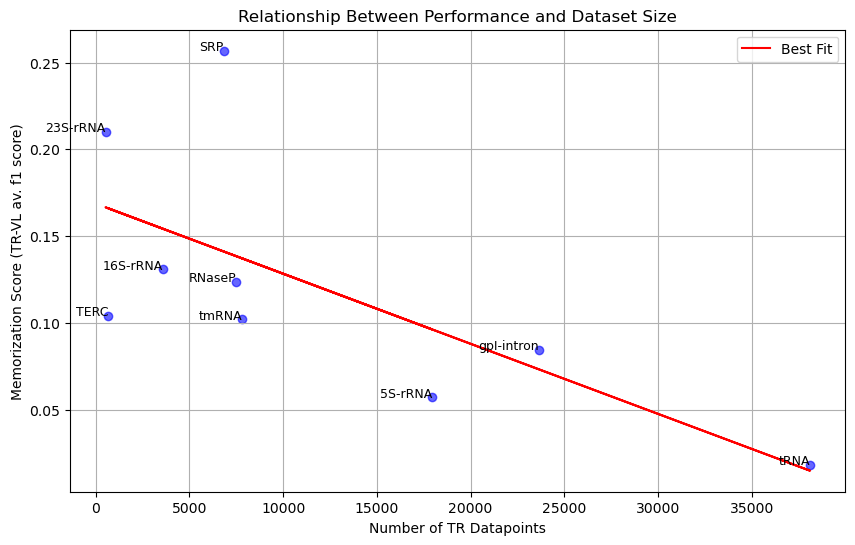

In [50]:
tr_datapoints = df_table['TR pop.'] # Extract TR Datapoints and Difference for plotting
f1_diff = df_table['Memorization Score']

plt.figure(figsize=(10, 6)) # scatter plot
plt.scatter(tr_datapoints, f1_diff, color='b', alpha=0.6)

for i, moltype in enumerate(df_table['Moltype']): # Add labels to each point
    plt.text(tr_datapoints[i], f1_diff[i], moltype, fontsize=9, ha='right')

# Calculate and plot line of best fit
m, b = np.polyfit(tr_datapoints, f1_diff, 1)  # line of best fit

plt.plot(tr_datapoints, m*tr_datapoints + b, color='red', label='Best Fit')
plt.title('Relationship Between Performance and Dataset Size')
plt.xlabel('Number of TR Datapoints')
plt.ylabel('Memorization Score (TR-VL av. f1 score)')
plt.legend()
plt.grid(True)
plt.show()
